# IN - XGBoost Analysis

In [0]:
from pyspark.sql.functions import col, udf, expr, pandas_udf, to_date, date_trunc, concat_ws, collect_list, struct, broadcast, row_number
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import when
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.sql.types import IntegerType, StringType, StructType, StructField, DoubleType, DateType, TimestampType, ArrayType, FloatType, LongType
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix
import numpy as np
from pyspark.sql import Window
from pyspark.sql.functions import date_add, to_timestamp, PandasUDFType
from pyspark.sql.functions import col, unix_timestamp, from_unixtime
import pandas as pd
from prophet import Prophet
# import tensorflow
# import xgboost
# import graphframes
from pyspark.ml.feature import Imputer
from sklearn.preprocessing import LabelEncoder
# import numpy as np
import math
from xgboost.spark import SparkXGBClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import mlflow

print("Welcome to the W261 final project!") 

Welcome to the W261 final project!


In [0]:
# import tensorflow

# Connect to team storage blob

In [0]:
# The following blob storage is accessible to team members only (read and write)
# access key is valid til TTL
# after that you will need to create a new SAS key and authenticate access again via DataBrick command line
blob_container  = "team-3-2-project261"       # The name of your container created in https://portal.azure.com
storage_account = "fall2024team32"  # The name of your Storage account created in https://portal.azure.com
secret_scope    = "scope_team_3_2"           # The name of the scope created in your local computer using the Databricks CLI
secret_key      = "key_team_3_2"             # The name of the secret key created in your local computer using the Databricks CLI
team_blob_url   = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"  #points to the root of your team storage bucket


# the 261 course blob storage is mounted here.
mids261_mount_path      = "/mnt/mids-w261"

# SAS Token: Grant the team limited access to Azure Storage resources
spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

# Check the listing in team blob

In [0]:
# IN check the listing in team blob
display(dbutils.fs.ls(f"{team_blob_url}"))

path,name,size,modificationTime
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_cancelled_data/,12m_cancelled_data/,0,1731754303000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_diverted_data/,12m_diverted_data/,0,1731754311000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_duplicates_removed/,12m_duplicates_removed/,0,1733298522000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_final_data/,12m_final_data/,0,1731755226000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_final_data_deduped/,12m_final_data_deduped/,0,1731805979000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_mean_year_month_destination/,12m_mean_year_month_destination/,0,1731754740000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_mean_year_month_origin/,12m_mean_year_month_origin/,0,1731754736000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_null_summary/,12m_null_summary/,0,1731754630000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_sorted_data/,12m_sorted_data/,0,1731754292000
wasbs://team-3-2-project261@fall2024team32.blob.core.windows.net/12m_summary_statistics/,12m_summary_statistics/,0,1731756196000



# Know your mount
Here is the mounting for this class, your source for the original data! Remember, you only have Read access, not Write! Also, become familiar with `dbutils` the equivalent of `gcp` in DataProc

In [0]:
data_BASE_DIR = "dbfs:/mnt/mids-w261/"
display(dbutils.fs.ls(f"{data_BASE_DIR}"))

path,name,size,modificationTime
dbfs:/mnt/mids-w261/HW5/,HW5/,0,0
dbfs:/mnt/mids-w261/OTPW_12M/,OTPW_12M/,0,1721794777000
dbfs:/mnt/mids-w261/OTPW_12M_2015.parquet/,OTPW_12M_2015.parquet/,0,1721930011000
dbfs:/mnt/mids-w261/OTPW_12M_2015_cleaned_sorted.parquet/,OTPW_12M_2015_cleaned_sorted.parquet/,0,1731891699000
dbfs:/mnt/mids-w261/OTPW_12M_2015_prepared.parquet/,OTPW_12M_2015_prepared.parquet/,0,1732139010000
dbfs:/mnt/mids-w261/OTPW_12M_2015_sorted.parquet/,OTPW_12M_2015_sorted.parquet/,0,1731652365000
dbfs:/mnt/mids-w261/OTPW_1D_CSV/,OTPW_1D_CSV/,0,0
dbfs:/mnt/mids-w261/OTPW_36M/,OTPW_36M/,0,0
dbfs:/mnt/mids-w261/OTPW_3M/,OTPW_3M/,0,1721832995000
dbfs:/mnt/mids-w261/OTPW_3M_2015.csv,OTPW_3M_2015.csv,1500620247,1679772070000


# EDA for new features

In [0]:
# Load saved data with features from blob
# data_col_cleaned_fe = spark.read.parquet(f"{team_blob_url}/data_cleaned_ordered_with_feature_engineerings_12m_v5")
# data_col_cleaned_fe = spark.read.parquet(f"{team_blob_url}/data_cleaned_ordered_with_feature_engineerings_60m_v3")
data_col_cleaned_fe = spark.read.parquet(f"{team_blob_url}/data_cleaned_ordered_with_feature_engineerings_60m_v4")

In [0]:
# if new_features are not loaded before this point
new_features = list(set([
    "DEP_DELAY_COUNT_3600sec",
    "DEP_DELAY_COUNT_7200sec",
    "ARR_DELAY_COUNT_3600sec",
    "ARR_DELAY_COUNT_7200sec",
    "CANCELLED_DELAY_COUNT_3600sec",
    "CANCELLED_DELAY_COUNT_7200sec",
    # 'InDegreeOrigin', 
    # 'OutDegreeOrigin', 
    # 'TotalDegreeOrigin'
] + ['Lag_same_flight_DEP_DELAY_NEW',
 'Avg_DEP_DELAY_NEW_other_flights',
 'Avg_TAXI_OUT_other_flights',
 'Last_DEP_DELAY_NEW_other_flights',
 'Last_TAXI_OUT_other_flights',
#  'Avg_ARR_DELAY_NEW_other_flights',
#  'Avg_TAXI_IN_other_flights',
#  'Last_ARR_DELAY_NEW_other_flights',
#  'Last_TAXI_IN_other_flights',
#  'Weekly_avg_DEP_DELAY_NEW_hat',
 'Monthly_avg_DEP_DELAY_NEW_hat',
 'origin_code_vector',
 'dest_code_vector',
 'Out_degree_same_origin_past_3hr', # corrected from 'In_degree_same_origin_past_3hr', and 'Out_degree_same_dest_past_3hr'
 'In_degree_same_dest_past_3hr'])- set(['origin_code_vector','dest_code_vector']))

 #IN: remove 'origin_code_vector' and 'dest_code_vector' given they are not numerical and more of an encoding than new features and hard to do numercial related EDA

In [0]:
def calculate_spearman_correlation_IN(input_df, target_col, numeric_cols_list):
    ranked_df = input_df.select(target_col, *numeric_cols_list)
    # numeric_cols = self.data.significant_numerical_columns
    for col_name in numeric_cols_list:
        window_spec = Window.orderBy(col_name)
        ranked_df = ranked_df.withColumn(f"{col_name}_rank", F.percent_rank().over(window_spec))
    
    correlation_results = []
    for col_name in numeric_cols_list:
        corr_value = ranked_df.stat.corr(f"{target_col}", f"{col_name}_rank")
        correlation_results.append((target_col, col_name, corr_value))
    
    # spark = SparkProcessor.get_spark_session()
    spearman_corr_df = spark.createDataFrame(correlation_results, ["TargetColumn", "NumericColumn", "Spearman_Correlation"])
    return spearman_corr_df

In [0]:
summary_df = data_col_cleaned_fe.select(new_features).summary()
display(summary_df)


summary,DEP_DELAY_COUNT_7200sec,Avg_TAXI_OUT_other_flights,Avg_DEP_DELAY_NEW_other_flights,ARR_DELAY_COUNT_3600sec,DEP_DELAY_COUNT_3600sec,Lag_same_flight_DEP_DELAY_NEW,CANCELLED_DELAY_COUNT_3600sec,ARR_DELAY_COUNT_7200sec,Monthly_avg_DEP_DELAY_NEW_hat,Last_TAXI_OUT_other_flights,Last_DEP_DELAY_NEW_other_flights,Out_degree_same_origin_past_3hr,CANCELLED_DELAY_COUNT_7200sec,In_degree_same_dest_past_3hr
count,31105479,26539620,26539620,31105479,31105479,31097593,31105479,31105479,30241770,26539620,26539620,31105479,31105479,31105479
mean,14.346784211231725,16.604347805401343,10.59491043603634,7.152950417513262,7.311049027729166,7.171774548596092,0.23534567656071137,14.156446039618936,28.9162437669848,16.288448402803056,11.909458763915987,57.33695873964841,0.46272034582717725,56.84083334643392
stddev,16.35999078741419,5.801456104251095,17.108870999118604,8.65415169868542,8.633878253755716,36.431606072031215,1.1327541425211316,16.33157187743933,45.848816826575245,9.139781454868084,40.39695317013535,52.953442158354015,2.0892513997538282,53.949114258082
min,0,1.0,0.0,0,0,-120.0,0,0,-278.2632577287803,1.0,0.0,0,0,0
25%,2,13.153846153846153,2.6363636363636362,1,1,0.0,0,3,5.977055607252411,11.0,0.0,15,0,14
50%,9,15.666666666666666,6.6875,4,4,0.0,0,9,13.000728810250758,14.0,0.0,44,0,42
75%,21,18.51219512195122,12.858695652173912,10,10,4.0,0,20,23.853239687087466,19.0,6.0,82,0,81
max,174,161.0,2007.0,100,101,2710.0,77,178,200.91822015234678,227.0,2710.0,288,135,297


In [0]:
# New features' basic statistics chart
summary_pdf = summary_df.toPandas()
summary_pdf = summary_pdf.set_index('summary').T

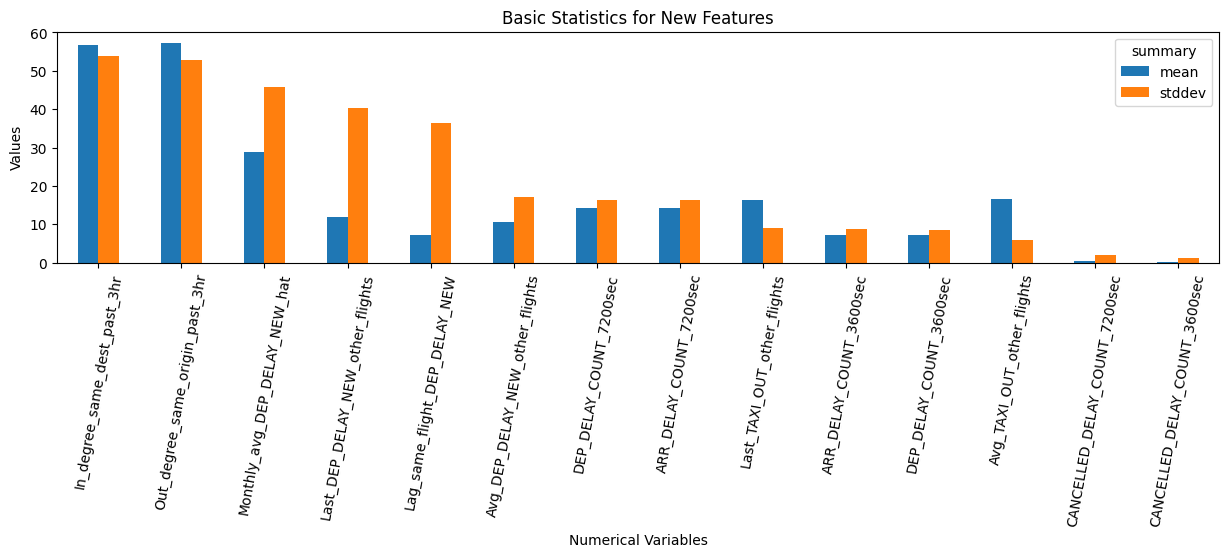

In [0]:
# ploting
summary_pdf[['mean','stddev']].astype(float).sort_values(by='stddev', ascending=False)\
    .plot(figsize=(15, 3), kind='bar')
plt.title('Basic Statistics for New Features')
plt.xlabel('Numerical Variables')
plt.ylabel('Values')
plt.xticks(rotation=80)
plt.show()

In [0]:
# Spearman correlation for new features
spearman_corr_df_new_features = calculate_spearman_correlation_IN(data_col_cleaned_fe, 'DEP_DELAY_GROUP_NEW', new_features)
display(spearman_corr_df_new_features)

TargetColumn,NumericColumn,Spearman_Correlation
DEP_DELAY_GROUP_NEW,DEP_DELAY_COUNT_7200sec,0.20682268496882217
DEP_DELAY_GROUP_NEW,Avg_TAXI_OUT_other_flights,0.1455264080423282
DEP_DELAY_GROUP_NEW,Avg_DEP_DELAY_NEW_other_flights,0.252171941669886
DEP_DELAY_GROUP_NEW,ARR_DELAY_COUNT_3600sec,0.1721269358260281
DEP_DELAY_GROUP_NEW,DEP_DELAY_COUNT_3600sec,0.19242669298164924
DEP_DELAY_GROUP_NEW,In_degree_same_origin_past_3hr,0.09564518486685752
DEP_DELAY_GROUP_NEW,Lag_same_flight_DEP_DELAY_NEW,0.25561994588697484
DEP_DELAY_GROUP_NEW,Out_degree_same_dest_past_3hr,0.03197816604662055
DEP_DELAY_GROUP_NEW,CANCELLED_DELAY_COUNT_3600sec,0.10546226962710664
DEP_DELAY_GROUP_NEW,ARR_DELAY_COUNT_7200sec,0.1869533801999586


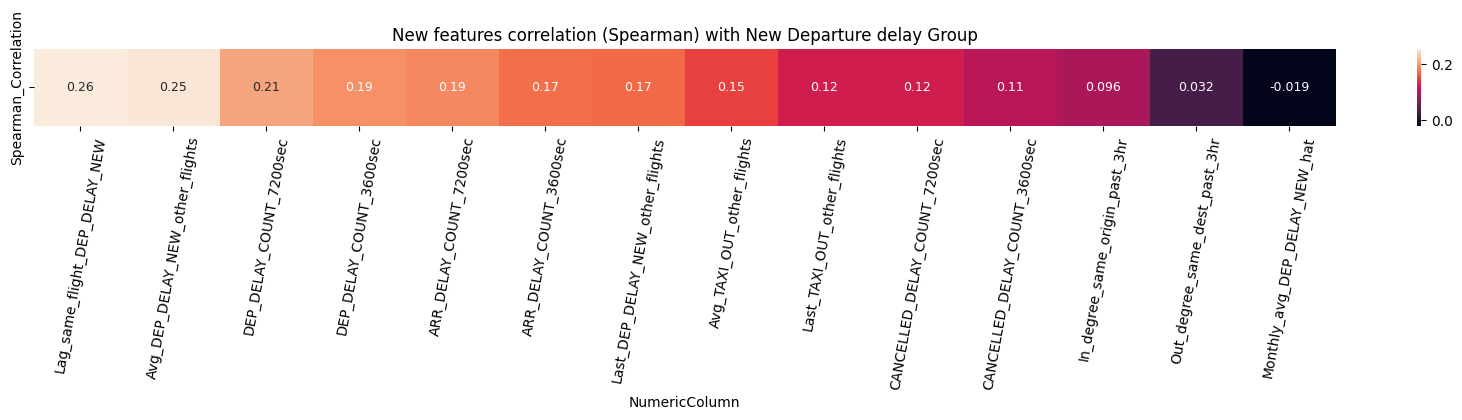

In [0]:
# IN visualization of spearman correlation - new features
spearman_corr_nf_pd = spearman_corr_df_new_features.toPandas()
spearman_corr_nf_pd = spearman_corr_nf_pd[['NumericColumn','Spearman_Correlation']]\
    .set_index('NumericColumn').sort_values(by='Spearman_Correlation', ascending=False)

plt.figure(figsize=(21,1))
hm = sns.heatmap(spearman_corr_nf_pd.T, annot=True, annot_kws={'size':9})
plt.title('New features correlation (Spearman) with New Departure delay Group')
plt.xticks(rotation=80)
plt.show()

In [0]:
# len(data_col_cleaned_fe.columns)
spark.catalog.clearCache()

# Gather the data in preparation of modeling

In [0]:
# If the ordered data is already in the blob
# data_encoded_scaled_ordered = (spark.read.parquet(f"{team_blob_url}/data_encoded_scaled_ordered_3m/"))

# retrieve the encoded scaled and ordered train and test data from the blob
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_3m/"))
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_3m_v4/"))
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_12m/"))
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_12m_v5/"))
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_60m_v2/"))
# train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_60m_v3/"))
train_val_df = (spark.read.parquet(f"{team_blob_url}/train_val_data_encoded_scaled_ordered_60m_v4/"))

# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_3m/"))
# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_3m_v4/"))
# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_12m/"))
# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_12m_v5/"))
# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_60m_v2/"))
# test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_60m_v3/"))
test_df = (spark.read.parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_60m_v4/"))

scaled_cols = (spark.read.parquet(f"{team_blob_url}/scaled_cols_60m_v4/"))

In [0]:
## Add row_id in the test data for modle essemble purpose later
test_df = test_df.withColumn("row_id_for_pred", row_number().over(Window.partitionBy().orderBy("two_hours_prior_depart_UTC")))
test_df.write.mode("overwrite").parquet(f"{team_blob_url}/test_data_encoded_scaled_ordered_60m_v4/")

In [0]:
display(test_df.dtypes)

_1,_2
origin_type,string
year_month,timestamp
TAIL_NUM,string
two_hours_prior_depart_UTC,timestamp
DEP_DELAY_GROUP,int
sched_depart_date_time_UTC,timestamp
four_hours_prior_depart_UTC,timestamp
FL_DATE,date
DEP_DELAY_NEW,double
TAXI_OUT,double


In [0]:
print((train_val_df).select('YEAR').distinct().collect())
# print((val_df).select('MONTH').distinct().collect())
print((test_df).select('YEAR').distinct().collect())

[Row(YEAR=2018), Row(YEAR=2015), Row(YEAR=2016), Row(YEAR=2017)]
[Row(YEAR=2019)]


# Pipeline for CV and Grid Search

## CV to split train_val_df to train_df and test_df

In [0]:
from pyspark.sql.functions import row_number, col
from pyspark.sql.window import Window
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Undersample function from Muthum
def delay_groups_fractions(df, source, tgt_label):
    print(f'Dataset: {source}')
    total_count = df.count()
    label_counts_df = df.groupBy(tgt_label).count()

    # Find the minimum class count
    min_count = label_counts_df.agg(F.min('count')).collect()[0][0]

    # Calculate percentage and fraction of min count
    grouped_df = label_counts_df.\
                    withColumn("percentage", (label_counts_df['count'] / total_count) * 100).\
                    withColumn("fraction", min_count/label_counts_df['count'])

    grouped_df.show()

    # Assuming df is your DataFrame with 'key_column' and 'value_column'
    fractions = dict(grouped_df.select(tgt_label, "fraction").\
                    rdd.map(lambda x: (x[0], x[1])).collect())

    return fractions

# From AG (mostly, with my modification)
def split_folds_train_val(df, leakage_pct=0.02, val_pct=0.1, n_folds=6, delay_col="DEP_DELAY_GROUP_NEW", version='NA', data_month_label='NA'):
    # Split train, test
    train_val_rows = df.count()

    train_val_df = df.withColumn("row_id", row_number().over(Window.partitionBy().orderBy("two_hours_prior_depart_UTC")))

    # Split folds.
    fold_size = train_val_rows // n_folds
    val_size = int(fold_size * val_pct)
    splits = []

    train_start_idx = 0
    for fold in range(1, n_folds): # IN: added start from 1
        # Define train and validation boundaries
        if fold >1:
            train_start_idx = val_end_idx #IN: add to do block train_df instead of expanding window train_df
        train_end_idx = (fold) * fold_size # IN: remove 1+ to make sure the last train_end_idx is not the end of the entire window so that it leaves room for validation set for this split
        leakage_cnt = int(fold_size * leakage_pct)
        val_start_idx = train_end_idx - leakage_cnt
        val_end_idx = train_end_idx + val_size + leakage_cnt

        # Avoid caching too much. It runs out of memory.
        train_df = train_val_df.filter(
            (col("row_id") >= train_start_idx) & (
            col("row_id") < train_end_idx))

        # Get validation set
        val_df = train_val_df.filter(
            (col("row_id") >= val_start_idx) & (col("row_id") < val_end_idx)
        )

        print(f"Fold: {fold}, train_start_idx: {train_start_idx}, train_end_idx: {train_end_idx}, val_start_idx: {val_start_idx}, val_end_idx: {val_end_idx}")

        # Show brief summary.
        train_fraction = delay_groups_fractions(train_df, "Train", delay_col)

        # Commented out to speed it up a little more.
        val_fraction = delay_groups_fractions(val_df, "Val", delay_col)

        # Safety bounds checking. We "shouldn't" need to do it for max(0.0, v).
        train_fraction = {k: min(1.0, v) for k, v in train_fraction.items()}

        # Undersample train data for imbalance treatment.
        train_df = train_df.sampleBy(delay_col, train_fraction, seed=20)

        # Save split data into blob
        
        train_df.write.mode("overwrite").parquet(f"{team_blob_url}/IN_{data_month_label}_fold_{fold}_train_{version}")
        val_df.write.mode("overwrite").parquet(f"{team_blob_url}/IN_{data_month_label}_fold_{fold}_val_{version}")

        # Append everything.
        splits.append((train_df, val_df))

    return splits

In [0]:
def get_pipeline_lr():
    # Defaults
    label_col = "DEP_DELAY_GROUP_NEW"
    features_col = "final_features_mod"
    # regularization_params = [0.001, 0.01, 0.1, 0.5, 1.0]
    # elastic_net_params = [0.0, 0.25, 0.5, 0.75, 1.0]
    regularization_params = [0, 0.01, 0.1]
    elastic_net_params = [0.0, 0.5, 1.0]

    # Define Logistic Regression.
    lr = LogisticRegression(featuresCol=features_col, labelCol=label_col)

    # Define parameter grid search.
    param_grid = (
        ParamGridBuilder()
        .addGrid(lr.regParam, regularization_params)
        .addGrid(lr.elasticNetParam, elastic_net_params)
        .build()
    )

    # Class we want to improve.
    focused_class = 2.0

    # Recall
    f_beta = 2.0

    evaluator = MulticlassClassificationEvaluator(
        labelCol=label_col,
        predictionCol="prediction",
        metricLabel=focused_class,
        metricName="fMeasureByLabel",
        beta=f_beta,
    )

    # NOTE: We can put the assembler in the pipeline, but it consumed too much memory when training.
    return Pipeline(stages=[lr]), param_grid, evaluator

def get_pipeline_xgboost():
    # Defaults
    label_col = "DEP_DELAY_GROUP_NEW"
    features_col = "final_features_mod"
    # for LR
    # regularization_params = [0.001, 0.01, 0.1, 0.5, 1.0]
    # elastic_net_params = [0.0, 0.25, 0.5, 0.75, 1.0]
    # regularization_params = [0, 0.01, 0.1]
    # elastic_net_params = [0.0, 0.5, 1.0]

    # for XGBOOST -1
    # learning_rate_params = [0.1, 0.3] #default: 0.3
    # max_depth_prams = [3, 6] #default: 6
    # # min_child_weight_params = [2, 3, 5] 
    # subsample_params = [0.5, 1] #default: 1
    # reg_lambda_params = [0, 1] #default: 1, L2 regularization
    # reg_alpha_params = [0, 1] #default: 0, L1 regularization

    # for xgboost -2
    # learning_rate_params = [0.1, 0.3] #default: 0.3
    # max_depth_prams = [6, 8] #default: 6
    # subsample_params = [0.6, 1] #default: 1
    # # additional params from Vini's 207 week 7 notebook (n_estimators (num_parallel_tree, max_iter, num_boost_round?), scale_pos_weight, subsample, learning_rate, gamma, colsample_bytree, colsample_bylevel, max_depth, alpha)
    # scale_pos_weight_params = [1, 2] #default 1, useful for unbalanced classes. A typical value to consider: sum(negative instances) / sum(positive instances)
    # gamma_params = [3, 5] # alias: gamma, default 0
    # colsample_bytree_params = [0.8, 0.9] # default: 1
    # colsample_bylevel_params = [0.9, 1] # default: 1

    # for xgboost -3
    # learning_rate_params = [0.3, 0.5] #default: 0.3
    # max_depth_prams = [8, 10] #default: 6
    # gamma_params = [0, 3] # alias: gamma, default 0
    # colsample_bytree_params = [0.8] # default: 1
    # colsample_bylevel_params = [0.9] # default: 1
    # n_estimators_params = [100,200] # default: 10 (? per gpt, suggest 50-100 for small data; 500-1000 for bigger data with early stopping maybe at 50)
    # # early_stopping_rounds_params =[50]

    # for xgboost -4
    # learning_rate_params = [0.3, 0.5] #default: 0.3
    # max_depth_prams = [6, 10, 12] #default: 6
    # gamma_params = [0] # alias: gamma, default 0
    # colsample_bytree_params = [0.8] # default: 1
    # colsample_bylevel_params = [0.9] # default: 1
    # n_estimators_params = [100, 200] # default: 10 (? per gpt, suggest 50-100 for small data; 500-1000 for bigger data with early stopping maybe at 50)
    # # early_stopping_rounds_params =[50]

    # # for xgboost -5 (unfinished)
    # learning_rate_params = [0.3, 0.5] #default: 0.3
    # max_depth_prams = [10, 12, 15] #default: 6
    # gamma_params = [0] # alias: gamma, default 0
    # colsample_bytree_params = [0.8] # default: 1
    # colsample_bylevel_params = [0.9] # default: 1
    # n_estimators_params = [100, 200, 250] # default: 10 (? per gpt, suggest 50-100 for small data; 500-1000 for bigger data with early stopping maybe at 50)
    # reg_alpha_params = [0,1] #default: 0, L1 regularization (?)
    # # early_stopping_rounds_params =[50]

    # # for xgboost -5-1 (makeup)
    # learning_rate_params = [0.5] #default: 0.3
    # max_depth_prams = [12] #default: 6
    # gamma_params = [0] # alias: gamma, default 0
    # colsample_bytree_params = [0.8] # default: 1
    # colsample_bylevel_params = [0.9] # default: 1
    # n_estimators_params = [250] # default: 10 (? per gpt, suggest 50-100 for small data; 500-1000 for bigger data with early stopping maybe at 50)
    # reg_alpha_params = [1] #default: 0, L1 regularization (?)
    # # early_stopping_rounds_params =[50]

    # # for xgboost -5-2 (makeup)
    # learning_rate_params = [0.5] #default: 0.3
    # max_depth_prams = [15] #default: 6
    # gamma_params = [0] # alias: gamma, default 0
    # colsample_bytree_params = [0.8] # default: 1
    # colsample_bylevel_params = [0.9] # default: 1
    # n_estimators_params = [100,200,250] # default: 10 (? per gpt, suggest 50-100 for small data; 500-1000 for bigger data with early stopping maybe at 50)
    # reg_alpha_params = [0,1] #default: 0, L1 regularization (?)
    # # early_stopping_rounds_params =[50]

    # for xgboost -5-3 (makeup)
    learning_rate_params = [0.5] #default: 0.3
    max_depth_prams = [15] #default: 6
    gamma_params = [0] # alias: gamma, default 0
    colsample_bytree_params = [0.8] # default: 1
    colsample_bylevel_params = [0.9] # default: 1
    n_estimators_params = [200,250] # default: 10 (? per gpt, suggest 50-100 for small data; 500-1000 for bigger data with early stopping maybe at 50)
    reg_alpha_params = [0,1] #default: 0, L1 regularization (?)
    # early_stopping_rounds_params =[50]

    # Define Logistic Regression.
    xg_clf = SparkXGBClassifier(
        features_col=features_col, 
        label_col=label_col,
        prediction_col = 'prediction',
        # numClass =3,
        num_class =3,
        num_workers=8,
        seed=42
       ) 

    # Define parameter grid search.
    # param_grid_1 = (
    #     ParamGridBuilder()
    #     .addGrid(xg_clf.learning_rate, learning_rate_params)
    #     .addGrid(xg_clf.max_depth, max_depth_prams)
    #     .addGrid(xg_clf.subsample, subsample_params)
    #     .addGrid(xg_clf.reg_lambda, reg_lambda_params)
    #     .addGrid(xg_clf.reg_alpha, reg_alpha_params)
    #     .build()
    # )

    # param_grid_2 = (
    #     ParamGridBuilder()
    #     .addGrid(xg_clf.learning_rate, learning_rate_params)
    #     .addGrid(xg_clf.max_depth, max_depth_prams)
    #     .addGrid(xg_clf.subsample, subsample_params)
    #     .addGrid(xg_clf.scale_pos_weight, scale_pos_weight_params)
    #     .addGrid(xg_clf.gamma, gamma_params)
    #     .addGrid(xg_clf.colsample_bytree, colsample_bytree_params)
    #     .addGrid(xg_clf.colsample_bylevel, colsample_bylevel_params)
    #     .build()
    # )

    # param_grid_3 = (
    #     ParamGridBuilder()
    #     .addGrid(xg_clf.learning_rate, learning_rate_params)
    #     .addGrid(xg_clf.max_depth, max_depth_prams)
    #     .addGrid(xg_clf.gamma, gamma_params)
    #     .addGrid(xg_clf.colsample_bytree, colsample_bytree_params)
    #     .addGrid(xg_clf.colsample_bylevel, colsample_bylevel_params)
    #     .addGrid(xg_clf.n_estimators, n_estimators_params)
    #     # .addGrid(xg_clf.early_stopping_rounds, early_stopping_rounds_params)
    #     .build()
    # )

    # param_grid_4 = (
    #     ParamGridBuilder()
    #     .addGrid(xg_clf.learning_rate, learning_rate_params)
    #     .addGrid(xg_clf.max_depth, max_depth_prams)
    #     .addGrid(xg_clf.gamma, gamma_params)
    #     .addGrid(xg_clf.colsample_bytree, colsample_bytree_params)
    #     .addGrid(xg_clf.colsample_bylevel, colsample_bylevel_params)
    #     .addGrid(xg_clf.n_estimators, n_estimators_params)
    #     # .addGrid(xg_clf.early_stopping_rounds, early_stopping_rounds_params)
    #     .build()
    # )

    param_grid = (
        ParamGridBuilder()
        .addGrid(xg_clf.learning_rate, learning_rate_params)
        .addGrid(xg_clf.max_depth, max_depth_prams)
        .addGrid(xg_clf.gamma, gamma_params)
        .addGrid(xg_clf.colsample_bytree, colsample_bytree_params)
        .addGrid(xg_clf.colsample_bylevel, colsample_bylevel_params)
        .addGrid(xg_clf.n_estimators, n_estimators_params)
        .addGrid(xg_clf.reg_alpha, reg_alpha_params)
        # .addGrid(xg_clf.early_stopping_rounds, early_stopping_rounds_params)
        .build()
    )

    # Class we want to improve.
    focused_class = 2.0

    # Recall
    f_beta = 2.0

    evaluator = MulticlassClassificationEvaluator(
        labelCol=label_col,
        predictionCol="prediction",
        metricLabel=focused_class,
        metricName="fMeasureByLabel",
        beta=f_beta,
    )

    # NOTE: We can put the assembler in the pipeline, but it consumed too much memory when training.
    return Pipeline(stages=[xg_clf]), param_grid, evaluator


def train_and_evaluate_chunk(train_assembled_df, val_assembled_df, pipeline_with_params, evaluator):
    pipeline_model = pipeline_with_params.fit(train_assembled_df)

    # NOTE: Evaluating the train set won't fit in memory.

    # Evaluate on the validation set
    val_pred = pipeline_model.transform(val_assembled_df)

    return evaluator.evaluate(val_pred)


def evaluate_ema(ema_val_f_beta, fold_f_beta, alpha=0.3):
    ema_val_f_beta = alpha * fold_f_beta + (1 - alpha) * ema_val_f_beta
    return ema_val_f_beta

def evaluate_w_weight(fold_idx, ema_val_f_beta, fold_f_beta):
    weight_dic = {0:0.1, 1:0.15, 2:0.2, 3:0.25, 4:0.3}
    return ema_val_f_beta + weight_dic[fold_idx]*fold_f_beta

def train_pipeline(splits, pipeline, param_grid, evaluator):
    best_params = None
    best_val_f_beta = float("-inf")

    param_list = []
    f_beta_list = []

    # NOTE: `splits` is assembled already to save memory.

    # Smoothing factor.
    alpha = 0.3

    # Iterate over each parameter combination
    for params in param_grid:
        # Set the parameters in the pipeline.
        pipeline_with_params = pipeline.copy(params)

        # Define exponential moving average.
        ema_val_f_beta = 0

        # Perform k-fold cross-validation
        for fold_idx, (train_assembled_df, val_assembled_df) in enumerate(splits):
            print(f"Training Fold {fold_idx + 1}")

            # Train each chunk.
            fold_f_beta = train_and_evaluate_chunk(
                train_assembled_df, val_assembled_df, pipeline_with_params, evaluator
            )

            if fold_idx == 0:
                # Initialize.
                # ema_val_f_beta = fold_f_beta
                ema_val_f_beta = evaluate_w_weight(fold_idx, 0.0, fold_f_beta)
                
            else:
                # Calculate EMA.
                # ema_val_f_beta = evaluate_ema(
                #     ema_val_f_beta=ema_val_f_beta, fold_f_beta=fold_f_beta, alpha=alpha
                # )
                ema_val_f_beta = evaluate_w_weight(fold_idx, ema_val_f_beta, fold_f_beta)
            
            print(
                f"Fold {fold_idx + 1} F-beta: {fold_f_beta}, Updated EMA: {ema_val_f_beta}"
            )

        print("----------------------------------------------")
        print("----------------------------------------------")
        print(f"params: {params}, ema_val_f_beta: {ema_val_f_beta}\n\n")

        if ema_val_f_beta > best_val_f_beta:
            best_val_f_beta = ema_val_f_beta
            best_params = params
        
        # IN: to keep the results for all params
        param_list.append(params)
        f_beta_list.append(ema_val_f_beta)

    return ({
        "best_params": best_params,
        "best_val_f_beta": best_val_f_beta,
    }, param_list, f_beta_list)


In [0]:
# Generate splits for CV
# version, data_month_label = 'v4', '12m'
version, data_month_label = 'v3_2', '60m'

splits = split_folds_train_val(df=train_val_df, version=version, data_month_label=data_month_label)

Fold: 1, train_start_idx: 0, train_end_idx: 3977240, val_start_idx: 3897696, val_end_idx: 4454508
Dataset: Train
+-------------------+-------+------------------+------------------+
|DEP_DELAY_GROUP_NEW|  count|        percentage|          fraction|
+-------------------+-------+------------------+------------------+
|                  0|2215578|  55.7064335334135|0.3535407013429453|
|                  1| 978364|24.599074885869317|0.8006191969451043|
|                  2| 783297|19.694491580717177|               1.0|
+-------------------+-------+------------------+------------------+

Dataset: Val
+-------------------+------+------------------+-------------------+
|DEP_DELAY_GROUP_NEW| count|        percentage|           fraction|
+-------------------+------+------------------+-------------------+
|                  2| 70870| 12.72781477410688|                1.0|
|                  0|360881| 64.81200117813553|0.19638052432796407|
|                  1|125061|22.460184047757593| 0.5666834

In [0]:
## if the split already exists, load the split from blob
# version, data_month_label = 'v4', '12m'
# version, data_month_label = 'v2', '60m'
version, data_month_label = 'v3', '60m'

# IN_12m_fold_1_train_v4/

splits = []
for fold in range(1,5+1):
    print (f'Loading fold_{fold}:')
    train_df_f = spark.read.parquet(f"{team_blob_url}/IN_{data_month_label}_fold_{fold}_train_{version}")
    val_df_f = spark.read.parquet(f"{team_blob_url}/IN_{data_month_label}_fold_{fold}_val_{version}")
    splits.append((train_df_f, val_df_f))


Loading fold_1:
Loading fold_2:
Loading fold_3:
Loading fold_4:
Loading fold_5:


In [0]:
# Assemble final features and create relevant columns for each CV split
cols_to_be_assembled_mod = ['scaled_features'] + list({x for x in train_val_df.columns if '_Encoded' in x} - {'origin_type_Encoded', 'dest_type_Encoded'} - {'ORIGIN_Encoded', 'DEST_Encoded'})\
    + ['origin_code_vector', 'dest_code_vector']

assembler = VectorAssembler(inputCols=cols_to_be_assembled_mod, outputCol='final_features_mod')

assembled_CV_splits = [
    (
        assembler.transform(train_df).select("DEP_DELAY_GROUP_NEW", "final_features_mod"),
        assembler.transform(val_df).select("DEP_DELAY_GROUP_NEW", "final_features_mod")
    )
    for train_df, val_df in splits
]

assembled_test_df = assembler.transform(test_df).select("DEP_DELAY_GROUP_NEW", "final_features_mod")

In [0]:
cols_to_be_assembled_mod

['scaled_features',
 'DEP_TIME_BLK_Encoded',
 'DAY_OF_WEEK_Encoded',
 'MONTH_Encoded',
 'QUARTER_Encoded',
 'OP_UNIQUE_CARRIER_Encoded',
 'YEAR_Encoded',
 'ARR_TIME_BLK_Encoded',
 'DAY_OF_MONTH_Encoded',
 'origin_code_vector',
 'dest_code_vector']

In [0]:
# from 60m data output for reference:
new_features = ['DEP_DELAY_COUNT_3600sec',
 'DEP_DELAY_COUNT_7200sec',
 'ARR_DELAY_COUNT_3600sec',
 'ARR_DELAY_COUNT_7200sec',
 'CANCELLED_DELAY_COUNT_3600sec',
 'CANCELLED_DELAY_COUNT_7200sec',
 'Lag_same_flight_DEP_DELAY_NEW',
 'Avg_DEP_DELAY_NEW_other_flights',
 'Avg_TAXI_OUT_other_flights',
 'Last_DEP_DELAY_NEW_other_flights',
 'Last_TAXI_OUT_other_flights',
 'Monthly_avg_DEP_DELAY_NEW_hat',
 'origin_code_vector',
 'dest_code_vector',
 'In_degree_same_origin_past_3hr',
 'Out_degree_same_dest_past_3hr']


scaled_cols = ['ARR_DELAY_COUNT_3600sec',
 'ARR_DELAY_COUNT_7200sec',
 'Avg_DEP_DELAY_NEW_other_flights',
 'Avg_TAXI_OUT_other_flights',
 'CANCELLED_DELAY_COUNT_3600sec',
 'CANCELLED_DELAY_COUNT_7200sec',
 'DEP_DELAY_COUNT_3600sec',
 'DEP_DELAY_COUNT_7200sec',
 'DISTANCE',
 'ELEVATION',
 'HourlyAltimeterSetting',
 'HourlyDryBulbTemperature',
 'HourlyPrecipitation',
 'HourlyRelativeHumidity',
 'HourlySeaLevelPressure',
 'HourlyStationPressure',
 'HourlyVisibility',
 'HourlyWindDirection',
 'HourlyWindSpeed',
 'In_degree_same_origin_past_3hr',
 'Lag_same_flight_DEP_DELAY_NEW',
 'Last_DEP_DELAY_NEW_other_flights',
 'Last_TAXI_OUT_other_flights',
 'Monthly_avg_DEP_DELAY_NEW_hat',
 'Out_degree_same_dest_past_3hr',
 'dest_type_Encoded',
 'origin_type_Encoded']


cols_to_be_assembled_mod= ['scaled_features',
 'DEP_TIME_BLK_Encoded',
 'DAY_OF_WEEK_Encoded',
 'MONTH_Encoded',
 'QUARTER_Encoded',
 'OP_UNIQUE_CARRIER_Encoded',
 'YEAR_Encoded',
 'ARR_TIME_BLK_Encoded',
 'DAY_OF_MONTH_Encoded',
 'origin_code_vector',
 'dest_code_vector']

all_mod_features =['ARR_DELAY_COUNT_3600sec',
 'ARR_DELAY_COUNT_7200sec',
 'Avg_DEP_DELAY_NEW_other_flights',
 'Avg_TAXI_OUT_other_flights',
 'CANCELLED_DELAY_COUNT_3600sec',
 'CANCELLED_DELAY_COUNT_7200sec',
 'DEP_DELAY_COUNT_3600sec',
 'DEP_DELAY_COUNT_7200sec',
 'DISTANCE',
 'ELEVATION',
 'HourlyAltimeterSetting',
 'HourlyDryBulbTemperature',
 'HourlyPrecipitation',
 'HourlyRelativeHumidity',
 'HourlySeaLevelPressure',
 'HourlyStationPressure',
 'HourlyVisibility',
 'HourlyWindDirection',
 'HourlyWindSpeed',
 'In_degree_same_origin_past_3hr',
 'Lag_same_flight_DEP_DELAY_NEW',
 'Last_DEP_DELAY_NEW_other_flights',
 'Last_TAXI_OUT_other_flights',
 'Monthly_avg_DEP_DELAY_NEW_hat',
 'Out_degree_same_dest_past_3hr',
 'dest_type_Encoded',
 'origin_type_Encoded',
 'DEP_TIME_BLK_Encoded',
 'DAY_OF_WEEK_Encoded',
 'MONTH_Encoded',
 'QUARTER_Encoded',
 'OP_UNIQUE_CARRIER_Encoded',
 'YEAR_Encoded',
 'ARR_TIME_BLK_Encoded',
 'DAY_OF_MONTH_Encoded',
 'origin_code_vector',
 'dest_code_vector']

In [0]:
# Total mod features
all_mod_features = (scaled_cols + cols_to_be_assembled_mod)
all_mod_features.remove('scaled_features')
all_mod_features

['ARR_DELAY_COUNT_3600sec',
 'ARR_DELAY_COUNT_7200sec',
 'Avg_DEP_DELAY_NEW_other_flights',
 'Avg_TAXI_OUT_other_flights',
 'CANCELLED_DELAY_COUNT_3600sec',
 'CANCELLED_DELAY_COUNT_7200sec',
 'DEP_DELAY_COUNT_3600sec',
 'DEP_DELAY_COUNT_7200sec',
 'DISTANCE',
 'ELEVATION',
 'HourlyAltimeterSetting',
 'HourlyDryBulbTemperature',
 'HourlyPrecipitation',
 'HourlyRelativeHumidity',
 'HourlySeaLevelPressure',
 'HourlyStationPressure',
 'HourlyVisibility',
 'HourlyWindDirection',
 'HourlyWindSpeed',
 'In_degree_same_origin_past_3hr',
 'Lag_same_flight_DEP_DELAY_NEW',
 'Last_DEP_DELAY_NEW_other_flights',
 'Last_TAXI_OUT_other_flights',
 'Monthly_avg_DEP_DELAY_NEW_hat',
 'Out_degree_same_dest_past_3hr',
 'dest_type_Encoded',
 'origin_type_Encoded',
 'DEP_TIME_BLK_Encoded',
 'DAY_OF_WEEK_Encoded',
 'MONTH_Encoded',
 'QUARTER_Encoded',
 'OP_UNIQUE_CARRIER_Encoded',
 'YEAR_Encoded',
 'ARR_TIME_BLK_Encoded',
 'DAY_OF_MONTH_Encoded',
 'origin_code_vector',
 'dest_code_vector']

In [0]:
mlflow.spark.autolog()

# pipeline_mod, param_grid, evaluator = get_pipeline_lr()
pipeline_mod, param_grid, evaluator = get_pipeline_xgboost()

best_params_and_metrics_dic, param_list, f_beta_list = train_pipeline(assembled_CV_splits, pipeline_mod, param_grid, evaluator)

best_params = best_params_and_metrics_dic['best_params']
best_metrics = best_params_and_metrics_dic['best_val_f_beta']


2024/12/08 07:22:34 WARNING mlflow.spark: With Pyspark >= 3.2, PYSPARK_PIN_THREAD environment variable must be set to false for Spark datasource autologging to work.


Training Fold 1


2024-12-08 07:23:02,106 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 0, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 07:40:28,624 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 1 F-beta: 0.4947275163144474, Updated EMA: 0.04947275163144474
Training Fold 2


2024-12-08 07:43:12,870 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 0, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 07:58:13,307 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 2 F-beta: 0.5899659682897263, Updated EMA: 0.13796764687490368
Training Fold 3


2024-12-08 08:00:41,918 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 0, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 08:16:52,125 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 3 F-beta: 0.5554233603214987, Updated EMA: 0.24905231893920343
Training Fold 4


2024-12-08 08:18:56,473 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 0, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 08:35:10,590 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 4 F-beta: 0.4954876726930839, Updated EMA: 0.3729242371124744
Training Fold 5


2024-12-08 08:36:56,349 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 0, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 08:52:42,235 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 5 F-beta: 0.6152481764979274, Updated EMA: 0.5574986900618526
----------------------------------------------
----------------------------------------------
params: {Param(parent='SparkXGBClassifier_4dcd5e612a03', name='learning_rate', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param learning_rate'): 0.5, Param(parent='SparkXGBClassifier_4dcd5e612a03', name='max_depth', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param max_depth'): 15, Param(parent='SparkXGBClassifier_4dcd5e612a03', name='gamma', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param gamma'): 0, Param(parent='SparkXGBClassifier_4dcd5e612a03', name='colsample_bytree', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param colsample_bytree'): 0.8, Param(parent='SparkXGBClassifier_4dcd5e612a03', name='colsample_bylevel', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param colsample_bylevel'): 0.9, Param(parent=

2024-12-08 08:54:33,580 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 1, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 09:15:07,833 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 1 F-beta: 0.49137696941484205, Updated EMA: 0.049137696941484205
Training Fold 2


2024-12-08 09:17:02,021 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 1, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 09:34:31,971 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 2 F-beta: 0.5937034375762708, Updated EMA: 0.13819321257792483
Training Fold 3


2024-12-08 09:36:33,646 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 1, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 09:54:43,146 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 3 F-beta: 0.5565773054619896, Updated EMA: 0.24950867367032276
Training Fold 4


2024-12-08 09:56:33,580 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 1, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 10:15:07,755 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 4 F-beta: 0.4999188906646159, Updated EMA: 0.37448839633647674
Training Fold 5


2024-12-08 10:17:11,751 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 1, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 200}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 10:35:33,916 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 5 F-beta: 0.6179271584443232, Updated EMA: 0.5598665438697736
----------------------------------------------
----------------------------------------------
params: {Param(parent='SparkXGBClassifier_4dcd5e612a03', name='learning_rate', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param learning_rate'): 0.5, Param(parent='SparkXGBClassifier_4dcd5e612a03', name='max_depth', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param max_depth'): 15, Param(parent='SparkXGBClassifier_4dcd5e612a03', name='gamma', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param gamma'): 0, Param(parent='SparkXGBClassifier_4dcd5e612a03', name='colsample_bytree', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param colsample_bytree'): 0.8, Param(parent='SparkXGBClassifier_4dcd5e612a03', name='colsample_bylevel', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param colsample_bylevel'): 0.9, Param(parent=

2024-12-08 10:37:35,813 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 0, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 11:00:08,989 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 1 F-beta: 0.4892483998037351, Updated EMA: 0.04892483998037351
Training Fold 2


2024-12-08 11:02:15,914 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 0, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 11:21:07,550 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 2 F-beta: 0.5917868625296081, Updated EMA: 0.13769286935981473
Training Fold 3


2024-12-08 11:23:12,473 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 0, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 11:43:15,586 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 3 F-beta: 0.555992991059317, Updated EMA: 0.24889146757167813
Training Fold 4


2024-12-08 11:45:36,593 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 0, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 12:05:34,071 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 4 F-beta: 0.49068276348784473, Updated EMA: 0.3715621584436393
Training Fold 5


2024-12-08 12:08:16,726 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 0, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 12:28:08,773 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 5 F-beta: 0.616813212212938, Updated EMA: 0.5566061221075207
----------------------------------------------
----------------------------------------------
params: {Param(parent='SparkXGBClassifier_4dcd5e612a03', name='learning_rate', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param learning_rate'): 0.5, Param(parent='SparkXGBClassifier_4dcd5e612a03', name='max_depth', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param max_depth'): 15, Param(parent='SparkXGBClassifier_4dcd5e612a03', name='gamma', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param gamma'): 0, Param(parent='SparkXGBClassifier_4dcd5e612a03', name='colsample_bytree', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param colsample_bytree'): 0.8, Param(parent='SparkXGBClassifier_4dcd5e612a03', name='colsample_bylevel', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param colsample_bylevel'): 0.9, Param(parent='

2024-12-08 12:30:28,423 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 1, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 12:56:40,884 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 1 F-beta: 0.49102788206882564, Updated EMA: 0.04910278820688257
Training Fold 2


2024-12-08 12:58:58,616 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 1, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 13:20:19,805 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 2 F-beta: 0.591204308875764, Updated EMA: 0.13778343453824718
Training Fold 3


2024-12-08 13:22:52,874 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 1, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 13:45:27,627 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 3 F-beta: 0.5570725709769193, Updated EMA: 0.24919794873363105
Training Fold 4


2024-12-08 13:47:54,568 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 1, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 14:10:37,445 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 4 F-beta: 0.48891133674963844, Updated EMA: 0.37142578292104067
Training Fold 5


2024-12-08 14:13:08,988 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'colsample_bylevel': 0.9, 'colsample_bytree': 0.8, 'device': 'cpu', 'gamma': 0, 'learning_rate': 0.5, 'max_depth': 15, 'objective': 'multi:softprob', 'reg_alpha': 1, 'num_class': 3, 'seed': 42, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 250}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 14:36:05,888 INFO XGBoost-PySpark: _fit Finished xgboost training!


Fold 5 F-beta: 0.6189826624720695, Updated EMA: 0.5571205816626615
----------------------------------------------
----------------------------------------------
params: {Param(parent='SparkXGBClassifier_4dcd5e612a03', name='learning_rate', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param learning_rate'): 0.5, Param(parent='SparkXGBClassifier_4dcd5e612a03', name='max_depth', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param max_depth'): 15, Param(parent='SparkXGBClassifier_4dcd5e612a03', name='gamma', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param gamma'): 0, Param(parent='SparkXGBClassifier_4dcd5e612a03', name='colsample_bytree', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param colsample_bytree'): 0.8, Param(parent='SparkXGBClassifier_4dcd5e612a03', name='colsample_bylevel', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param colsample_bylevel'): 0.9, Param(parent=

In [0]:
best_params

{Param(parent='SparkXGBClassifier_4dcd5e612a03', name='learning_rate', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param learning_rate'): 0.5,
 Param(parent='SparkXGBClassifier_4dcd5e612a03', name='max_depth', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param max_depth'): 15,
 Param(parent='SparkXGBClassifier_4dcd5e612a03', name='gamma', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param gamma'): 0,
 Param(parent='SparkXGBClassifier_4dcd5e612a03', name='colsample_bytree', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param colsample_bytree'): 0.8,
 Param(parent='SparkXGBClassifier_4dcd5e612a03', name='colsample_bylevel', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param colsample_bylevel'): 0.9,
 Param(parent='SparkXGBClassifier_4dcd5e612a03', name='n_estimators', doc='Refer to XGBoost doc of xgboost.sklearn.XGBClassifier for this param n_estimators'): 200,
 Param(parent

In [0]:
best_metrics

0.5598665438697736

In [0]:
# IN: if read in cv_results from work space
# pip install openpyxl
cv_results = pd.read_excel('/Workspace/Users/sha.na.in.12@berkeley.edu/phase-3-cv-result-2.xlsx')
best_params = cv_results.iloc[np.argmax(cv_results['f_beta']),:-1]


In [0]:
best_params.rename('Best_param').to_frame()

,Best_param
Learning Rate,0.3
Max Depth,15.0
Gamma,0.0
Colsample Bytree,0.8
Colsample Bylevel,0.9
N Estimators,250.0
Reg Alpha,1.0


In [0]:
cv_results

,Learning Rate,Max Depth,Gamma,Colsample Bytree,Colsample Bylevel,N Estimators,Reg Alpha,f_beta
0,0.5,15,0,0.8,0.9,250,1,0.557121
1,0.5,15,0,0.8,0.9,250,0,0.556606
2,0.5,15,0,0.8,0.9,200,1,0.559867
3,0.5,15,0,0.8,0.9,200,0,0.557499
4,0.5,15,0,0.8,0.9,100,1,0.547019
5,0.5,15,0,0.8,0.9,100,0,0.544729
6,0.5,12,0,0.8,0.9,250,1,0.542298
7,0.5,12,0,0.8,0.9,250,0,0.537200
8,0.5,12,0,0.8,0.9,200,1,0.536100
9,0.5,12,0,0.8,0.9,200,0,0.535350


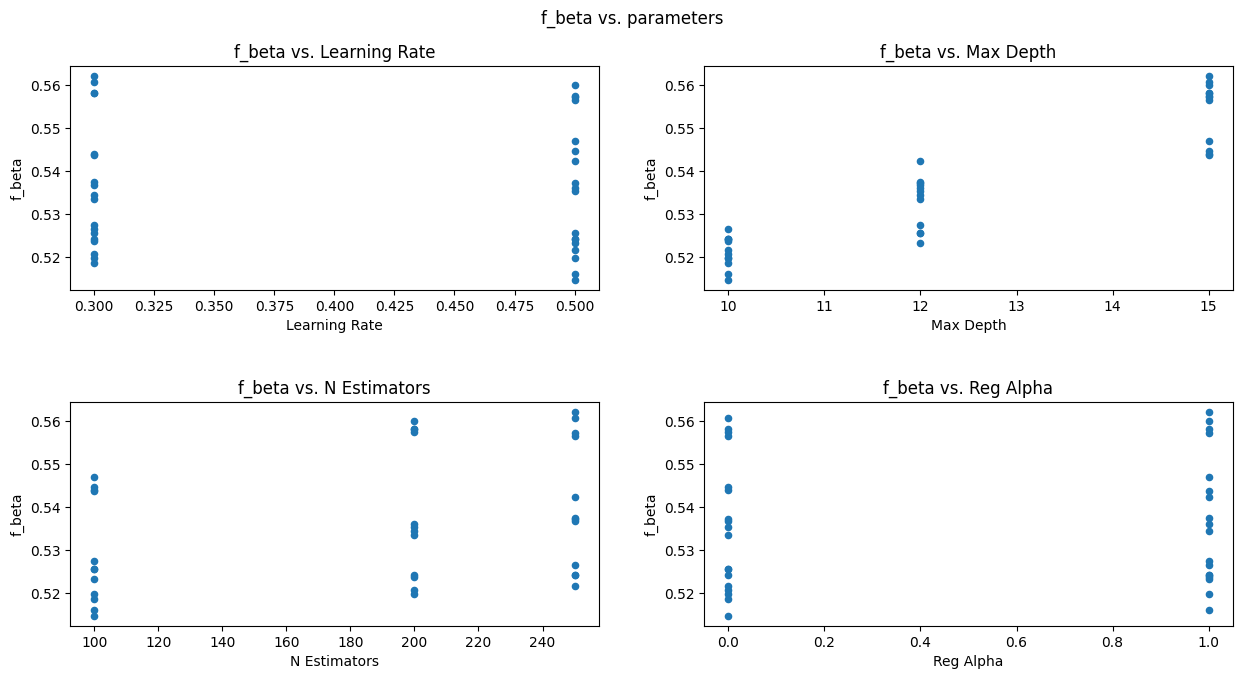

In [0]:
# preserve results (current run - 12/07/2024 -3-combned-full)
cv_results_to_plot = cv_results[[col_name for col_name in cv_results.columns if len(cv_results[col_name].unique())>1]]

num_plot_per_row = 2
fig_cv, ax_cv = plt.subplots(len(cv_results_to_plot.iloc[0,:])//num_plot_per_row, num_plot_per_row, figsize=(15,7))
for i, col in enumerate(cv_results_to_plot.columns[:-1]):
    cv_results_to_plot[[col, 'f_beta']].plot(ax = ax_cv[i//2, i%2], x=col, y='f_beta', kind='scatter')
    ax_cv[i//num_plot_per_row, i%num_plot_per_row].set_title('f_beta vs. '+col)
    ax_cv[i//num_plot_per_row, i%num_plot_per_row].set_xlabel(col)
    ax_cv[i//num_plot_per_row, i%num_plot_per_row].set_ylabel('f_beta')
fig_cv.suptitle('f_beta vs. parameters')
plt.subplots_adjust(top=0.90, bottom=0.1, hspace=0.5)
plt.show()

## Save CV related results

In [0]:
# Save CV related dataframes to blob storage
# res_saving_version = 'v3'  # 'v2'
# res_data_month_label = '12m'

res_saving_version = 'v3_comb'  # 'v2', 'v3_1','v3_2' ,'v3_3', 'v3_comb'
res_data_month_label = '60m'

spark.createDataFrame(pd.DataFrame([best_params])).write.mode('overwrite').parquet(f'{team_blob_url}/IN_best_params_test_xgboost_{res_data_month_label}_{res_saving_version}')
spark.createDataFrame(cv_results).write.mode('overwrite').parquet(f'{team_blob_url}/IN_cv_results_test_xgboost_{res_data_month_label}_{res_saving_version}')

## Train the final model

In [0]:
# Utile functions for training (if not run before)
# Undersample function from Muthum
def delay_groups_fractions(df, source, tgt_label):
    print(f'Dataset: {source}')
    total_count = df.count()
    label_counts_df = df.groupBy(tgt_label).count()

    # Find the minimum class count
    min_count = label_counts_df.agg(F.min('count')).collect()[0][0]

    # Calculate percentage and fraction of min count
    grouped_df = label_counts_df.\
                    withColumn("percentage", (label_counts_df['count'] / total_count) * 100).\
                    withColumn("fraction", min_count/label_counts_df['count'])

    grouped_df.show()

    # Assuming df is your DataFrame with 'key_column' and 'value_column'
    fractions = dict(grouped_df.select(tgt_label, "fraction").\
                    rdd.map(lambda x: (x[0], x[1])).collect())

    return fractions

def performance_per_label(input_pred, split_name, results_summary, f_beta):
  preAndlabels = input_pred.select(['prediction', 'DEP_DELAY_GROUP_NEW']).rdd.map(lambda x: (float(x['prediction']), float(x['DEP_DELAY_GROUP_NEW'])))

  # print(preAndlabels)

  # instantiate metrics object
  metrics = MulticlassMetrics(preAndlabels)

  # stats by class
  labels = [0.0, 1.0, 2.0]
  for label in sorted(labels):
    # print (label)
    print('\n%s Class %s F%s-Measure = %s'% (split_name, label, f_beta, metrics.fMeasure(label, f_beta)))
    print('%s Class %s precision = %s'% (split_name, label, metrics.precision(label)))
    print('%s Class %s recall = %s'% (split_name, label, metrics.recall(label)))

    results_summary.loc[f'Class {int(label)} F{f_beta}-Measure', split_name] = metrics.fMeasure(label, f_beta)
    results_summary.loc[f'CLass {int(label)} precision', split_name] =  metrics.precision(label)
    results_summary.loc[f'Class {int(label)} recall', split_name] = metrics.recall(label)

  return results_summary


def confusion_matrix_sklearn(y_orig, y_pred):
    """
    To plot the confusion_matrix with percentages
    prediction:  predicted values
    original:    original values
    """
    cm = confusion_matrix(y_orig, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(3, 3)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()


In [0]:
# Train the final model with train_val_df
def train_final_model(train_val_df, test_df, chosen_params=None):
    # undersample
    # undersample for imbalance treatment - on train data only
    fractions = delay_groups_fractions(train_val_df, 'Train_val', 'DEP_DELAY_GROUP_NEW')
    train_val_df = train_val_df.sampleBy("DEP_DELAY_GROUP_NEW", fractions, seed=20).cache()
    delay_groups_fractions(train_val_df, 'Train_val', 'DEP_DELAY_GROUP_NEW')
    delay_groups_fractions(test_df, 'Test', 'DEP_DELAY_GROUP_NEW')

    '''fit LR'''
    # mod = LogisticRegression(featuresCol='final_features_mod', labelCol='DEP_DELAY_GROUP_NEW')
    # # mod = mod.copy(chosen_params)
    # if chosen_params is not None:
    #     mod.setParams(params=chosen_params)
    # res_mod = mod.fit(train_val_df)

    '''fit XGboost'''
    mod = SparkXGBClassifier(
        features_col ='final_features_mod', 
        label_col='DEP_DELAY_GROUP_NEW',
        prediction_col = 'prediction',
        num_class =3,
        num_workers=8,
        seed=42

       ) 
    if chosen_params is not None:
        mod.setParams(params=chosen_params)
    res_mod = mod.fit(train_val_df)
    
    ''''''

    # Evaluate F1 score for each split of data
    focuse_class = 2.0
    f_beta = 2.0
    # evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DELAY_GROUP_NEW', predictionCol='prediction', metricName="f1")
    evaluator = MulticlassClassificationEvaluator(labelCol='DEP_DELAY_GROUP_NEW', predictionCol='prediction', 
                                                metricLabel=focuse_class, metricName="fMeasureByLabel", beta=f_beta)

    # Get F-beta scores for each split
    # training 
    train_pred = res_mod.transform(train_val_df).cache()
    train_fmeasure = evaluator.evaluate(train_pred)
    print(f'Training F-{f_beta} Score is {train_fmeasure}')

    # # validation 
    # val_pred = res_mod.transform(val_df).cache()
    # val_fmeasure = evaluator.evaluate(val_pred)
    # print(f'Validation F-{f_beta} Score is {val_fmeasure}')

    # testing 
    test_pred = res_mod.transform(test_df).cache()
    # test_pred = test_pred.fillna(0.0)
    test_fmeasure = evaluator.evaluate(test_pred)
    print(f'Test F-{f_beta} Score is {test_fmeasure}')

    # putting results together
    results_summary = pd.DataFrame({'Train': [train_fmeasure], 'Test': [test_fmeasure]},
                            index=[f'F{f_beta} score'])
    
    # Get per class F1 scores for each split
    split_names = ['Train', 'Test']
    pred_list = [train_pred, test_pred]

    for i in range(len(split_names)):
        split_name = split_names[i]
        pred_s = pred_list[i]
        results_summary = performance_per_label(pred_s, split_name, results_summary, float(f_beta))
    
    print()
    print(results_summary)
    print()
    
    # Generate the confusion matrix (for test split only)
    pred_conf_matrix = test_pred
    y_pred = pred_conf_matrix.select('prediction').collect()
    y_orig = pred_conf_matrix.select('DEP_DELAY_GROUP_NEW').collect()
    confusion_matrix_sklearn(y_orig, y_pred)

    return res_mod, results_summary, train_pred, test_pred


In [0]:
# If not set up before:
#for >60m data set
cols_to_be_assembled_mod =['scaled_features',
 'DEP_TIME_BLK_Encoded',
 'DAY_OF_WEEK_Encoded',
 'MONTH_Encoded',
 'QUARTER_Encoded', #IN: only for >=12m
 'OP_UNIQUE_CARRIER_Encoded',
 'YEAR_Encoded', #IN: only for >12m
 'ARR_TIME_BLK_Encoded',
 'DAY_OF_MONTH_Encoded',
 'origin_code_vector',
 'dest_code_vector']

assembler = VectorAssembler(inputCols=cols_to_be_assembled_mod, outputCol='final_features_mod')
assembled_test_df = assembler.transform(test_df).select("DEP_DELAY_GROUP_NEW", "final_features_mod")


In [0]:
## If best param is not in memory (note: dictionary will do)
# best_params ={'regParam': 0.01,'elasticNetParam': 0.5} # IN for LR

best_params_v1 = {'learning_rate': 0.3,
 'max_depth': 6,
 'subsample': 0.5,
 'reg_lambda': 1,
'reg_alpha': 1}

best_params_v2 = {'learning_rate': 0.3,
 'max_depth': 8,
 'subsample': 1.0,
 'scale_pos_weight': 1.0,
'gamma': 3.0,
'colsample_bytree': 0.8,
'colsample_bylevel': 0.9}

best_params_v2_2 = {'learning_rate': 0.3,
 'max_depth': 8,
 'subsample': 0.6,
 'scale_pos_weight': 1.0,
'gamma': 3.0,
'colsample_bytree': 0.8,
'colsample_bylevel': 0.9}

best_params_v3 = {'learning_rate': 0.5,
'max_depth': 10,
'gamma': 0.0,
'colsample_bytree': 0.8,
'colsample_bylevel': 0.9,
'n_estimator': 200}

best_params_v3_2 = {'learning_rate': 0.5,
'max_depth': 10,
'gamma': 0.0,
'colsample_bytree': 0.8,
'colsample_bylevel': 0.9,
'n_estimator': 200,
'subsample': 0.5}

best_params_v4 = {'learning_rate': 0.3,
'max_depth': 15,
'gamma': 0.0,
'colsample_bytree': 0.8,
'colsample_bylevel': 0.9,
'n_estimator': 250,
'reg_alpha': 1.0}

Dataset: Train_val
+-------------------+--------+------------------+------------------+
|DEP_DELAY_GROUP_NEW|   count|        percentage|          fraction|
+-------------------+--------+------------------+------------------+
|                  1| 5362115|22.469998250880995|0.8011821827767588|
|                  2| 4296031|18.002562245630784|               1.0|
|                  0|14205296|59.527439503488225|0.3024246027678691|
+-------------------+--------+------------------+------------------+

Dataset: Train_val
+-------------------+-------+------------------+------------------+
|DEP_DELAY_GROUP_NEW|  count|        percentage|          fraction|
+-------------------+-------+------------------+------------------+
|                  1|4297209|33.345676660441974|0.9991636431925931|
|                  2|4296031|  33.3365355627886|0.9994376204454763|
|                  0|4293615| 33.31778777676943|               1.0|
+-------------------+-------+------------------+------------------+

D

INFO:XGBoost-PySpark:Running xgboost-2.0.3 on 8 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 3, 'seed': 42, 'params': {'learning_rate': 0.3, 'max_depth': 15, 'gamma': 0.0, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'n_estimator': 250, 'reg_alpha': 1.0}, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


Training F-2.0 Score is 0.5749462875464847
Test F-2.0 Score is 0.5563917529278557


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Train Class 0.0 F2.0-Measure = 0.6357273373053554
Train Class 0.0 precision = 0.5414593820889428
Train Class 0.0 recall = 0.6646564724596873

Train Class 1.0 F2.0-Measure = 0.4490158317569688
Train Class 1.0 precision = 0.48718644458752236
Train Class 1.0 recall = 0.440389797191619

Train Class 2.0 F2.0-Measure = 0.5749462875464847
Train Class 2.0 precision = 0.6444780408383759
Train Class 2.0 recall = 0.559846053252409


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Test Class 0.0 F2.0-Measure = 0.6671222917658314
Test Class 0.0 precision = 0.7708062110951501
Test Class 0.0 recall = 0.645417919594939

Test Class 1.0 F2.0-Measure = 0.3918298835010569
Test Class 1.0 precision = 0.32755105277581187
Test Class 1.0 recall = 0.41204487161456305

Test Class 2.0 F2.0-Measure = 0.5563917529278557
Test Class 2.0 precision = 0.47195937095157636
Test Class 2.0 recall = 0.5824410753812442

                         Train      Test
F2.0 score            0.574946  0.556392
Class 0 F2.0-Measure  0.635727  0.667122
CLass 0 precision     0.541459  0.770806
Class 0 recall        0.664656  0.645418
Class 1 F2.0-Measure  0.449016  0.391830
CLass 1 precision     0.487186  0.327551
Class 1 recall        0.440390  0.412045
Class 2 F2.0-Measure  0.574946  0.556392
CLass 2 precision     0.644478  0.471959
Class 2 recall        0.559846  0.582441



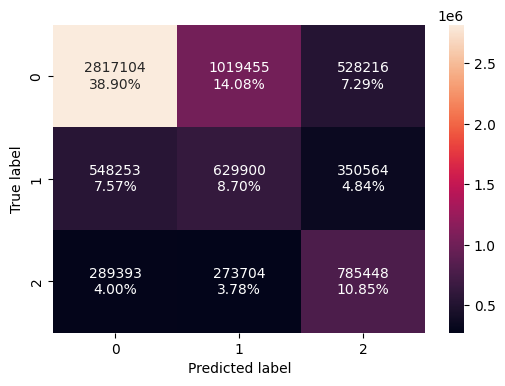

In [0]:
# Train the last model with CV chosen params '''results as of 12/11/2024, rerun to save model properly'''
chosen_params = best_params_v4
# chosen_params = None

assembled_train_val_df = assembler.transform(train_val_df).select("DEP_DELAY_GROUP_NEW", "final_features_mod")
assembled_test_df = assembler.transform(test_df) # leave all the column in test_df so we preserve row_id_pred, and other info, for later assemble purpose
final_mod, results_summary, train_pred, test_pred = train_final_model(assembled_train_val_df, 
                                               assembled_test_df, chosen_params)

In [0]:
results_summary # record the result as of 12/11/2024

,Train,Test
F2.0 score,0.574946,0.556392
Class 0 F2.0-Measure,0.635727,0.667122
CLass 0 precision,0.541459,0.770806
Class 0 recall,0.664656,0.645418
Class 1 F2.0-Measure,0.449016,0.391830
CLass 1 precision,0.487186,0.327551
Class 1 recall,0.440390,0.412045
Class 2 F2.0-Measure,0.574946,0.556392
CLass 2 precision,0.644478,0.471959
Class 2 recall,0.559846,0.582441


In [0]:
display(test_pred.dtypes)
display(test_pred.limit(10))

_1,_2
origin_type,string
year_month,timestamp
TAIL_NUM,string
two_hours_prior_depart_UTC,timestamp
DEP_DELAY_GROUP,int
sched_depart_date_time_UTC,timestamp
four_hours_prior_depart_UTC,timestamp
FL_DATE,date
DEP_DELAY_NEW,double
TAXI_OUT,double


origin_type,year_month,TAIL_NUM,two_hours_prior_depart_UTC,DEP_DELAY_GROUP,sched_depart_date_time_UTC,four_hours_prior_depart_UTC,FL_DATE,DEP_DELAY_NEW,TAXI_OUT,TAXI_IN,ARR_DELAY_NEW,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,DISTANCE,ELEVATION,HourlyAltimeterSetting,HourlyDryBulbTemperature,HourlyPrecipitation,HourlyRelativeHumidity,HourlySeaLevelPressure,HourlyStationPressure,HourlyVisibility,HourlyWindDirection,HourlyWindSpeed,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME_BLK,ARR_TIME_BLK,dest_type,OP_UNIQUE_CARRIER,ORIGIN,DEST,QUARTER,YEAR,DEP_DELAY_COUNT_3600sec,DEP_DELAY_COUNT_7200sec,ARR_DELAY_COUNT_3600sec,ARR_DELAY_COUNT_7200sec,CANCELLED_DELAY_COUNT_3600sec,CANCELLED_DELAY_COUNT_7200sec,Actual_departure_time_UTC,Actual_arrival_time_UTC,Lag_same_flight_DEP_DELAY_NEW,Avg_DEP_DELAY_NEW_other_flights,Last_DEP_DELAY_NEW_other_flights,Avg_TAXI_OUT_other_flights,Last_TAXI_OUT_other_flights,Monthly_avg_DEP_DELAY_NEW_hat,origin_code_vector,dest_code_vector,Out_degree_same_origin_past_3hr,In_degree_same_dest_past_3hr,DEP_DELAY_GROUP_NEW,origin_type_Encoded,dest_type_Encoded,MONTH_Encoded,DAY_OF_MONTH_Encoded,DAY_OF_WEEK_Encoded,OP_UNIQUE_CARRIER_Encoded,DEP_TIME_BLK_Encoded,ARR_TIME_BLK_Encoded,QUARTER_Encoded,YEAR_Encoded,scaled_features,row_id_for_pred,final_features_mod,rawPrediction,prediction,probability
medium_airport,2019-01-01T00:00:00Z,N656NK,2019-01-01T05:38:00Z,-1,2019-01-01T07:38:00Z,2019-01-01T03:38:00Z,2019-01-01,0.0,12.0,15.0,0.0,184.0,182.0,1176.0,178.3,29.559999465942383,44.0,0.001764705897692372,76.0,29.59000015258789,28.940000534057617,10.0,270.0,33.0,1,1,2,0001-0559,0001-0559,large_airport,NK,IAG,FLL,1,2019,0,0,0,0,0,0,2019-01-01T07:38:00Z,2019-01-01T10:40:00Z,3.0,11.664253965871069,13.093467190629838,17.182757151508387,16.84023913380178,16.733135421250395,"Map(vectorType -> sparse, length -> 9, indices -> List(1, 3, 5), values -> List(1.0, 1.0, 1.0))","Map(vectorType -> dense, length -> 9, values -> List(0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0))",0,12,0,1,2,"Map(vectorType -> sparse, length -> 12, indices -> List(10), values -> List(1.0))","Map(vectorType -> sparse, length -> 31, indices -> List(23), values -> List(1.0))","Map(vectorType -> sparse, length -> 7, indices -> List(4), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(8), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(16), values -> List(1.0))","Map(vectorType -> sparse, length -> 19, indices -> List(17), values -> List(1.0))","Map(vectorType -> sparse, length -> 4, indices -> List(3), values -> List(1.0))","Map(vectorType -> sparse, length -> 4, indices -> List(), values -> List())","Map(vectorType -> dense, length -> 27, values -> List(0.0, 0.0, 0.005811785732870487, 0.10114223219692742, 0.0, 0.0, 0.0, 0.0, 0.2316851664984864, 0.07565453927235635, 0.476027175798098, 0.5491329479768786, 3.0637253950855254E-4, 0.7575757575757577, 0.38989160477539425, 0.8147818336160104, 0.10058338547750634, 0.75, 0.01475189986589182, 0.04067796610169491, 0.047527047913446675, 0.006208377046292004, 0.08123199555795785, 0.6156256173641417, 0.0, 1.0, 0.5))",1,"Map(vectorType -> sparse, length -> 160, indices -> List(2, 3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 43, 50, 63, 68, 77, 109, 134, 143, 145, 147, 153, 154, 155, 156, 157, 158), values -> List(0.005811785732870487, 0.10114223219692742, 0.2316851664984864, 0.07565453927235635, 0.476027175798098, 0.5491329479768786, 3.0637253950855254E-4, 0.7575757575757577, 0.38989160477539425, 0.8147818336160104, 0.10058338547750634, 0.75, 0.01475189986589182, 0.04067796610169491, 0.047527047913446675, 0.006208377046292004, 0.08123199555795785, 0.6156256173641417, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0))","Map(vectorType -> dense, length -> 3, values -> List(0.4036584198474884, 0.5062925815582275, 0.168153315782547))",1.0,"Map(vectorType -> dense, length -> 3, values -> List(0.3450348973274231

Dataset: Train_val
+-------------------+--------+------------------+------------------+
|DEP_DELAY_GROUP_NEW|   count|        percentage|          fraction|
+-------------------+--------+------------------+------------------+
|                  1| 5362115|22.469998250880995|0.8011821827767588|
|                  2| 4296031|18.002562245630784|               1.0|
|                  0|14205296|59.527439503488225|0.3024246027678691|
+-------------------+--------+------------------+------------------+

Dataset: Train_val
+-------------------+-------+------------------+------------------+
|DEP_DELAY_GROUP_NEW|  count|        percentage|          fraction|
+-------------------+-------+------------------+------------------+
|                  1|4295548| 33.32717822544205|               1.0|
|                  2|4296031| 33.33092559995233|0.9998875706436942|
|                  0|4297445|33.341896174605615|0.9995585749206796|
+-------------------+-------+------------------+------------------+

D

2024-12-08 17:30:12,299 INFO XGBoost-PySpark: _fit Running xgboost-2.0.3 on 8 workers with
	booster params: {'objective': 'multi:softprob', 'device': 'cpu', 'num_class': 3, 'seed': 42, 'params': {'learning_rate': 0.3, 'max_depth': 15, 'gamma': 0.0, 'colsample_bytree': 0.8, 'colsample_bylevel': 0.9, 'n_estimator': 250, 'reg_alpha': 1.0}, 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
2024-12-08 17:35:01,083 INFO XGBoost-PySpark: _fit Finished xgboost training!


Training F-2.0 Score is 0.5746761031362863
Test F-2.0 Score is 0.5551420183251742


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Train Class 0.0 F2.0-Measure = 0.6354745217989181
Train Class 0.0 precision = 0.5413538724666206
Train Class 0.0 recall = 0.664350794483699

Train Class 1.0 F2.0-Measure = 0.4488667880082473
Train Class 1.0 precision = 0.4865837203888091
Train Class 1.0 recall = 0.4403338060708436

Train Class 2.0 F2.0-Measure = 0.5746761031362863
Train Class 2.0 precision = 0.6447356632386733
Train Class 2.0 recall = 0.5594773408292445


/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(



Test Class 0.0 F2.0-Measure = 0.6688615793579946
Test Class 0.0 precision = 0.7716541132013222
Test Class 0.0 recall = 0.6473046147854128

Test Class 1.0 F2.0-Measure = 0.39543313947491965
Test Class 1.0 precision = 0.3293235074661619
Test Class 1.0 recall = 0.4163268937285318

Test Class 2.0 F2.0-Measure = 0.5551420183251742
Test Class 2.0 precision = 0.4744330403599416
Test Class 2.0 recall = 0.5798004515978332

                         Train      Test
F2.0 score            0.574676  0.555142
Class 0 F2.0-Measure  0.635475  0.668862
CLass 0 precision     0.541354  0.771654
Class 0 recall        0.664351  0.647305
Class 1 F2.0-Measure  0.448867  0.395433
CLass 1 precision     0.486584  0.329324
Class 1 recall        0.440334  0.416327
Class 2 F2.0-Measure  0.574676  0.555142
CLass 2 precision     0.644736  0.474433
Class 2 recall        0.559477  0.579800



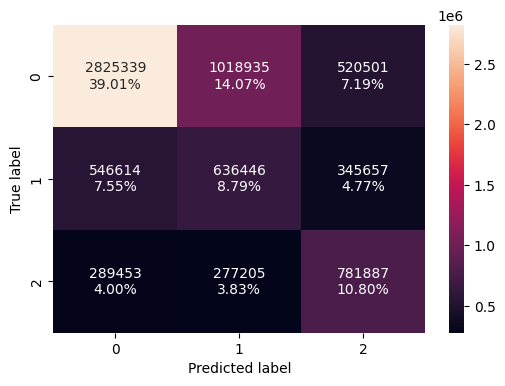

In [0]:
# Train the last model with CV chosen params '''keep the results as of 12/8/2024'''
chosen_params = best_params_v4
# chosen_params = None
assembled_train_val_df = assembler.transform(train_val_df).select("DEP_DELAY_GROUP_NEW", "final_features_mod")
assembled_test_df = assembler.transform(test_df) # leave all the column in test_df so we preserve row_id_pred, and other info, for later assemble purpose
final_mod, results_summary, train_pred, test_pred = train_final_model(assembled_train_val_df, 
                                               assembled_test_df, chosen_params)



In [0]:
results_summary # record the result as of 12/8/2024

,Train,Test
F2.0 score,0.574676,0.555142
Class 0 F2.0-Measure,0.635475,0.668862
CLass 0 precision,0.541354,0.771654
Class 0 recall,0.664351,0.647305
Class 1 F2.0-Measure,0.448867,0.395433
CLass 1 precision,0.486584,0.329324
Class 1 recall,0.440334,0.416327
Class 2 F2.0-Measure,0.574676,0.555142
CLass 2 precision,0.644736,0.474433
Class 2 recall,0.559477,0.579800


In [0]:
display(train_val_df.dtypes)

_1,_2
origin_type,string
year_month,timestamp
TAIL_NUM,string
two_hours_prior_depart_UTC,timestamp
DEP_DELAY_GROUP,int
sched_depart_date_time_UTC,timestamp
four_hours_prior_depart_UTC,timestamp
FL_DATE,date
DEP_DELAY_NEW,double
TAXI_OUT,double


In [0]:
# save xgboost model manually
# import xgboost as xgb
import pickle

# model_save_version = 'v3'
# month_label = '12m'
model_save_version = 'v2_after_cv' # 'v1_after_cv', 'v2_after_cv'
month_label = '60m'

## IN: these worked:

pickle.dump(final_mod.get_booster(), open(f'IN_xgboost_model_booster_{model_save_version}_{month_label}.pkl', 'wb'))
pickle.dump(results_summary, open(f'IN_xgboost_results_summary_{model_save_version}_{month_label}.pkl', 'wb'))

path_workspace = '/Workspace/Users/sha.na.in.12@berkeley.edu/'
final_mod.write().overwrite().save(f"{path_workspace}IN_xgboost_model_as_is_{model_save_version}_{month_label}.pkl")

# save test_pred to team blob for assemble use
test_pred.write.mode("overwrite").parquet(f"{team_blob_url}/IN_xgboost_model_test_pred_{model_save_version}_{month_label}")

In [0]:
from xgboost.spark import SparkXGBClassifierModel
import pickle
## load the model later
model_save_version = 'v2_after_cv'
month_label = '60m'

# load the model as is
model_loaded = SparkXGBClassifierModel.load(f'{path_workspace}IN_xgboost_model_as_is_{model_save_version}_{month_label}') #IN: note: add '.pkl' does not work, which is the opposite with LR
results_summary_loaded = pickle.load(open(f'IN_xgboost_results_summary_{model_save_version}_{month_label}.pkl', 'rb'))


## Feature importance analysis

In [0]:
## note: those orders are not correct most likely
# scaled_cols = (spark.read.parquet(f"{team_blob_url}/scaled_cols_12m_v5/"))
scaled_cols = (spark.read.parquet(f"{team_blob_url}/scaled_cols_60m_v3/"))

In [0]:
important_num_features = ['DEP_DELAY_NEW',
'TAXI_OUT',
'TAXI_IN',
'ARR_DELAY_NEW',
'CRS_ELAPSED_TIME',
'ACTUAL_ELAPSED_TIME',
'DISTANCE',
'ELEVATION',
'HourlyAltimeterSetting',
# 'HourlyDewPointTemperature',
'HourlyDryBulbTemperature',
'HourlyPrecipitation',
'HourlyRelativeHumidity',
'HourlySeaLevelPressure',
'HourlyStationPressure',
'HourlyVisibility',
# 'HourlyWetBulbTemperature',
'HourlyWindDirection',
'HourlyWindSpeed']

features_not_directly_available = [
'DEP_DELAY_NEW',
'ARR_DELAY_NEW',
'TAXI_OUT',
'TAXI_IN',
'CANCELLED',
'DIVERTED',
'ACTUAL_ELAPSED_TIME',
'Actual_vs_scheduled_elapsed_time'
]

In [0]:
# # for 12m dataset
# new_features = ['DEP_DELAY_COUNT_3600sec',
#  'DEP_DELAY_COUNT_7200sec',
#  'ARR_DELAY_COUNT_3600sec',
#  'ARR_DELAY_COUNT_7200sec',
#  'CANCELLED_DELAY_COUNT_3600sec',
#  'CANCELLED_DELAY_COUNT_7200sec',
#  'InDegreeOrigin',
#  'OutDegreeOrigin',
#  'TotalDegreeOrigin',
#  'Lag_same_flight_DEP_DELAY_NEW',
#  'Avg_DEP_DELAY_NEW_other_flights',
#  'Avg_TAXI_OUT_other_flights',
#  'Last_DEP_DELAY_NEW_other_flights',
#  'Last_TAXI_OUT_other_flights',
#  'Avg_ARR_DELAY_NEW_other_flights',
#  'Avg_TAXI_IN_other_flights',
#  'Last_ARR_DELAY_NEW_other_flights',
#  'Last_TAXI_IN_other_flights',
#  'Weekly_avg_DEP_DELAY_NEW_hat',
#  'origin_code_vector',
#  'dest_code_vector']

 # for 60m dataset
new_features = ['DEP_DELAY_COUNT_3600sec',
 'DEP_DELAY_COUNT_7200sec',
 'ARR_DELAY_COUNT_3600sec',
 'ARR_DELAY_COUNT_7200sec',
 'CANCELLED_DELAY_COUNT_3600sec',
 'CANCELLED_DELAY_COUNT_7200sec',
 'Lag_same_flight_DEP_DELAY_NEW',
 'Avg_DEP_DELAY_NEW_other_flights',
 'Avg_TAXI_OUT_other_flights',
 'Last_DEP_DELAY_NEW_other_flights',
 'Last_TAXI_OUT_other_flights',
 'Monthly_avg_DEP_DELAY_NEW_hat',
 'origin_code_vector',
 'dest_code_vector',
 'Out_degree_same_origin_past_3hr', # corrected from In_degree_same_origin_past_3hr
 'In_degree_same_dest_past_3hr'] # corrected from Out_degree_same_dest_past_3hr

In [0]:
scaled_cols_w_right_order = sorted(list(set(important_num_features).union(set(new_features))- {'ACTUAL_ELAPSED_TIME','CRS_ELAPSED_TIME'} - set(features_not_directly_available)
                   -set(['origin_code_vector', 'dest_code_vector']))+ ['origin_type_Encoded', 'dest_type_Encoded']) 
                   
# for 60m dataset
all_mod_features_w_right_order =  scaled_cols_w_right_order +\
['DEP_TIME_BLK_Encoded',
 'DAY_OF_WEEK_Encoded',
 'MONTH_Encoded',
 'QUARTER_Encoded',
 'OP_UNIQUE_CARRIER_Encoded',
 'YEAR_Encoded',
 'ARR_TIME_BLK_Encoded',
 'DAY_OF_MONTH_Encoded',
 'origin_code_vector',
 'dest_code_vector']

In [0]:
all_mod_features_w_right_order

['ARR_DELAY_COUNT_3600sec',
 'ARR_DELAY_COUNT_7200sec',
 'Avg_DEP_DELAY_NEW_other_flights',
 'Avg_TAXI_OUT_other_flights',
 'CANCELLED_DELAY_COUNT_3600sec',
 'CANCELLED_DELAY_COUNT_7200sec',
 'DEP_DELAY_COUNT_3600sec',
 'DEP_DELAY_COUNT_7200sec',
 'DISTANCE',
 'ELEVATION',
 'HourlyAltimeterSetting',
 'HourlyDryBulbTemperature',
 'HourlyPrecipitation',
 'HourlyRelativeHumidity',
 'HourlySeaLevelPressure',
 'HourlyStationPressure',
 'HourlyVisibility',
 'HourlyWindDirection',
 'HourlyWindSpeed',
 'In_degree_same_dest_past_3hr',
 'Lag_same_flight_DEP_DELAY_NEW',
 'Last_DEP_DELAY_NEW_other_flights',
 'Last_TAXI_OUT_other_flights',
 'Monthly_avg_DEP_DELAY_NEW_hat',
 'Out_degree_same_origin_past_3hr',
 'dest_type_Encoded',
 'origin_type_Encoded',
 'DEP_TIME_BLK_Encoded',
 'DAY_OF_WEEK_Encoded',
 'MONTH_Encoded',
 'QUARTER_Encoded',
 'OP_UNIQUE_CARRIER_Encoded',
 'YEAR_Encoded',
 'ARR_TIME_BLK_Encoded',
 'DAY_OF_MONTH_Encoded',
 'origin_code_vector',
 'dest_code_vector']

In [0]:
cat_encoded_col_dic = {'DEP_TIME_BLK_Encoded':19, 'ARR_TIME_BLK_Encoded':19, 
                       'DAY_OF_WEEK_Encoded':7, 'QUARTER_Encoded':4, 
                       'YEAR_Encoded':4, # 'YEAR_Encoded':4 for 60m dataset for train_val_df 
                       'MONTH_Encoded':12,  # 'MONTH_Encoded':10 for 12 month dataset for up to train_val_df; 12 for 60m dataset
                       'OP_UNIQUE_CARRIER_Encoded':19, # 14 for 12m; 19 for 60m dataset
                       'DAY_OF_MONTH_Encoded':31,
                       'origin_code_vector':9, 'dest_code_vector':9} # 8 for 12m; 9 for 60m dataset

In [0]:
len(all_mod_features_w_right_order)

len(sum([[x] if x not in cat_encoded_col_dic.keys() 
 else [f'{x}_{i}' for i in range(cat_encoded_col_dic[x])] for x in all_mod_features_w_right_order],[]))

all_mod_col_names = sum([[x] if x not in cat_encoded_col_dic.keys() 
 else [f'{x}_{i}' for i in range(cat_encoded_col_dic[x])] for x in all_mod_features_w_right_order],[])

## For xgboost

In [0]:
#If we are using the final from just trained model

## if load the full model
booster = model_loaded.get_booster()

In [0]:
# Get feature importances
feature_importances = booster.get_score(importance_type='weight')

# Map feature importances to feature names
# input_cols = assembler.getInputCols()

input_cols_guessed = all_mod_col_names
feature_importance_mapping = {input_cols_guessed[int(k[1:])]: v for k, v in feature_importances.items()}

# Print feature importances
print("Feature Importances:")
for feature, importance in feature_importance_mapping.items():
    print(f"{feature}: {importance}")

Feature Importances:
ARR_DELAY_COUNT_3600sec: 167.0
ARR_DELAY_COUNT_7200sec: 503.0
Avg_DEP_DELAY_NEW_other_flights: 702.0
Avg_TAXI_OUT_other_flights: 413.0
CANCELLED_DELAY_COUNT_3600sec: 54.0
CANCELLED_DELAY_COUNT_7200sec: 143.0
DEP_DELAY_COUNT_3600sec: 261.0
DEP_DELAY_COUNT_7200sec: 731.0
DISTANCE: 1227.0
ELEVATION: 849.0
HourlyAltimeterSetting: 125.0
HourlyDryBulbTemperature: 475.0
HourlyPrecipitation: 135.0
HourlyRelativeHumidity: 270.0
HourlySeaLevelPressure: 111.0
HourlyStationPressure: 254.0
HourlyVisibility: 81.0
HourlyWindDirection: 106.0
HourlyWindSpeed: 96.0
In_degree_same_dest_past_3hr: 1084.0
Lag_same_flight_DEP_DELAY_NEW: 2482.0
Last_DEP_DELAY_NEW_other_flights: 121.0
Last_TAXI_OUT_other_flights: 125.0
Monthly_avg_DEP_DELAY_NEW_hat: 248.0
Out_degree_same_origin_past_3hr: 949.0
dest_type_Encoded: 32.0
origin_type_Encoded: 71.0
DEP_TIME_BLK_Encoded_0: 177.0
DEP_TIME_BLK_Encoded_1: 162.0
DEP_TIME_BLK_Encoded_2: 177.0
DEP_TIME_BLK_Encoded_3: 37.0
DEP_TIME_BLK_Encoded_4: 24.0
D

In [0]:
pd.reset_option('display.max_rows')
coefficients_mod_pdf = pd.DataFrame(feature_importance_mapping, columns = feature_importance_mapping.keys(), index=['feature_importance']).T.sort_values(by='feature_importance', ascending=False)
coefficients_mod_pdf

,feature_importance
Lag_same_flight_DEP_DELAY_NEW,2482.0
DISTANCE,1227.0
In_degree_same_dest_past_3hr,1084.0
Out_degree_same_origin_past_3hr,949.0
ELEVATION,849.0
...,...
DAY_OF_MONTH_Encoded_23,8.0
DAY_OF_MONTH_Encoded_0,8.0
DAY_OF_MONTH_Encoded_17,7.0
DAY_OF_MONTH_Encoded_20,5.0


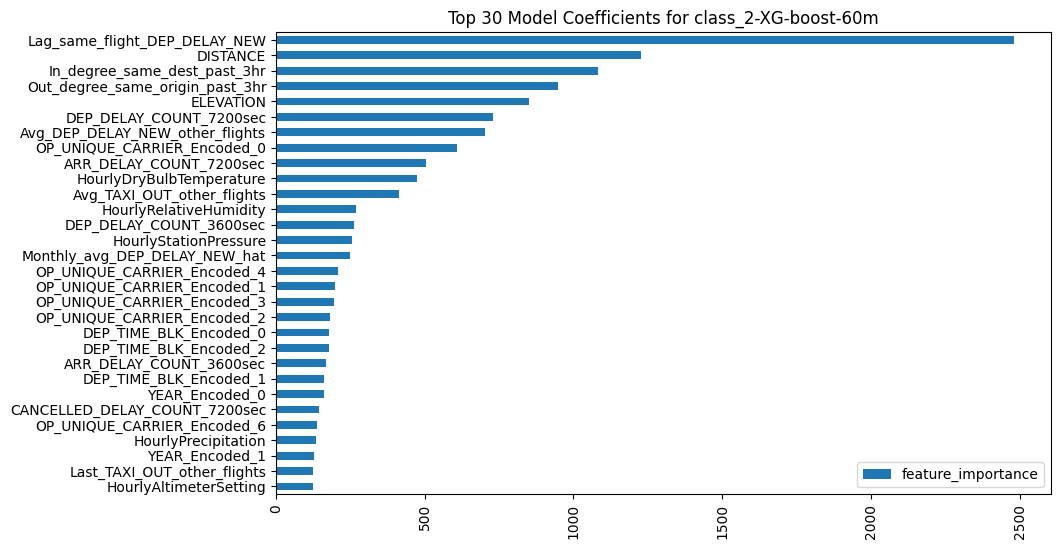

In [0]:
# coefficients_mod_pdf[:50].plot(kind='bar', title='Top 50 Model Coefficients for class_2-XG-boost-12m', figsize=(18,5))
# plt.xticks(rotation=80)
# plt.show()

coefficients_mod_pdf[:30].sort_values(by='feature_importance', ascending=True).plot(kind='barh', title='Top 30 Model Coefficients for class_2-XG-boost-60m', figsize=(10,6))
plt.xticks(rotation=90)
plt.show()

In [0]:
coefficients_mod_pdf[:20]

,feature_importance
Lag_same_flight_DEP_DELAY_NEW,2482.0
DISTANCE,1227.0
In_degree_same_dest_past_3hr,1084.0
Out_degree_same_origin_past_3hr,949.0
ELEVATION,849.0
DEP_DELAY_COUNT_7200sec,731.0
Avg_DEP_DELAY_NEW_other_flights,702.0
OP_UNIQUE_CARRIER_Encoded_0,610.0
ARR_DELAY_COUNT_7200sec,503.0
HourlyDryBulbTemperature,475.0
